In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

# construct "table de fait"
histories = pd.read_csv("yearHistoryTemplate.csv")
weather = pd.read_csv("weather2017.csv")
histories['DATE'] = pd.to_datetime(histories['dep_time'], format = '%Y-%m-%d').dt.date
weather['DATE'] = pd.to_datetime(weather['DATE'], format = '%Y-%m-%d').dt.date
histories['precipitation'] = histories['DATE'].map(weather.set_index('DATE')['PRECIP_TOTAL_DAY_MM'])
histories['visibility'] = histories['DATE'].map(weather.set_index('DATE')['VISIBILITY_AVG_KM'])
histories['month'] = pd.to_datetime(histories['dep_time'], format = '%Y-%m-%d').dt.month
histories['hour'] = pd.to_datetime(histories['dep_time'], format = '%Y-%m-%d').dt.hour
histories.head(10)

In [2]:
fait = histories.drop(['id','client_id', 'departure_id', 'arrival_id', 'vehicle_id',\
                       'dep_time', 'arr_time', 'base_price', 'sup_price', 'DATE'], axis=1)
fait.head(10)

,late_time,precipitation,visibility,month,hour
0,0,0.0,10.0,1,0
1,0,0.0,10.0,1,0
2,0,0.0,10.0,1,2
3,0,0.0,10.0,1,2
4,0,0.0,10.0,1,3
5,0,0.0,10.0,1,4
6,0,0.0,10.0,1,5
7,0,0.0,10.0,1,5
8,0,0.0,10.0,1,5
9,0,0.0,10.0,1,6


In [3]:
# DONNO HOW TO TRANSFER IT
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

In [4]:
# difinition Precipitation
# faible = <3.0mm
# moyen =  >= 3.0mm and < 5mm
# fort = >= 5mm
def rep_precip(x):
    if x < 3.0:
        return 'precip_faible'
    elif x >= 3. and x < 5.:
        return 'precip_moyen'
    else :
        return 'precip_fort'

# definition visibility
# faible = < 5km
# moyen = >= 5km and < 8km
# bonne = >= 8km
def rep_visib(x):
    if x < 5.:
        return 'visib_faible'
    elif x >= 5. and x < 8.:
        return 'visib_moyen'
    else :
        return 'visib_fort'

def if_late(x):
    if x != 0:
        return 1
    else:
        return 0
# definition month
# haute = 7, 8
# basse = other months
def rep_month(x):
    if x is 7 or x is 8:
        return 'month_haute'
    else:
        return 'month_basse'
# definition hour
# pointe = in 7, 8, 12, 13, 19, 20
# creuse in other hours
def rep_hour(x):
    if x in [7, 8, 12, 13, 19, 20]:
        return 'hour_pointe'
    else:
        return 'hour_creuse'
fait['precip'] = fait['precipitation'].apply(lambda x: rep_precip(x))
fait['visib'] = fait['visibility'].apply(lambda x: rep_visib(x))
fait['isLate'] = fait['late_time'].apply(lambda x: if_late(x))
fait['month'] = fait['month'].apply(lambda x: rep_month(x))
fait['hour'] = fait['hour'].apply(lambda x: rep_hour(x))
fait.drop(['late_time','visibility', 'precipitation'], axis=1, inplace=True)

fait.head(10)

,month,hour,precip,visib,isLate
0,month_basse,hour_creuse,precip_faible,visib_fort,0
1,month_basse,hour_creuse,precip_faible,visib_fort,0
2,month_basse,hour_creuse,precip_faible,visib_fort,0
3,month_basse,hour_creuse,precip_faible,visib_fort,0
4,month_basse,hour_creuse,precip_faible,visib_fort,0
5,month_basse,hour_creuse,precip_faible,visib_fort,0
6,month_basse,hour_creuse,precip_faible,visib_fort,0
7,month_basse,hour_creuse,precip_faible,visib_fort,0
8,month_basse,hour_creuse,precip_faible,visib_fort,0
9,month_basse,hour_creuse,precip_faible,visib_fort,0


In [5]:
dummies_col = ['month', 'hour', 'precip', 'visib']
for each in dummies_col:
     dummy = pd.get_dummies(fait[each])
     fait = pd.concat([fait, dummy], axis=1)
fait.drop(['month','hour', 'precip', 'visib'], axis=1, inplace=True)
fait.head(10)

,isLate,month_basse,month_haute,hour_creuse,hour_pointe,precip_faible,precip_fort,precip_moyen,visib_faible,visib_fort,visib_moyen
0,0,1,0,1,0,1,0,0,0,1,0
1,0,1,0,1,0,1,0,0,0,1,0
2,0,1,0,1,0,1,0,0,0,1,0
3,0,1,0,1,0,1,0,0,0,1,0
4,0,1,0,1,0,1,0,0,0,1,0
5,0,1,0,1,0,1,0,0,0,1,0
6,0,1,0,1,0,1,0,0,0,1,0
7,0,1,0,1,0,1,0,0,0,1,0
8,0,1,0,1,0,1,0,0,0,1,0
9,0,1,0,1,0,1,0,0,0,1,0


In [7]:
fait.to_csv("fait.csv")

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

faitX = fait.drop('isLate', axis=1)
x_train, x_test, y_train, y_test = train_test_split\
(faitX, fait.isLate, test_size=0.33, random_state=0)
lr = LogisticRegression()
lr.fit(x_train, y_train)
    

y_pred = lr.predict(x_test)
score = metrics.accuracy_score(y_test, y_pred)
print("With logistic regression, we got " + str(score) + "%")

With logistic regression, we got 0.846352033852%


In [94]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
score = metrics.accuracy_score(y_test, y_pred)
print("With bayes, we got " + str(score) + "%")

With bayes, we got 0.7789550914550915%


This ML is to predict if a cours is late. 
Features are precipitation, visibility month and hour. They are transfered in 0, 1, 2, three states.
Logistic regression shows better quality.

In [14]:
%pylab inline

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

Populating the interactive namespace from numpy and matplotlib


0.15195195195195196


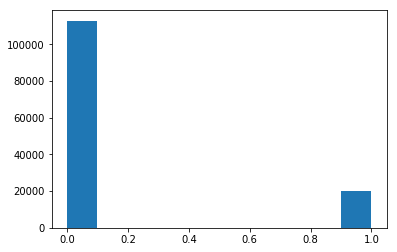

In [19]:
# Regardons la répartition de notre objectif

faitX = fait.drop('isLate', axis=1)
x_train, x_test, y_train, y_test = train_test_split\
(faitX, fait.isLate, test_size=0.25, random_state=0)
print(float(y_train.sum()/len(y_train)))

plt.hist(y_train)
None

In [41]:
# On essaie avec un arbre
model = RandomForestClassifier(n_estimators=1)

model.fit(x_train, y_train)
print(f'Training score {accuracy_score(model.predict(x_train), y_train) * 100:.1f}%')

print(f'Test score     {accuracy_score(model.predict(x_test), y_test) * 100:.1f}%')

Training score 84.9%
Test score     84.9%


In [43]:
# On définit une fonction que l'on va réutiliser pour scorer différents modèles

def score_model(model):
    """Réalise la validation croisée d'un modèle sur le training set uniquement
    puis affiche les résultats (moyenne et écart-type de la précision du modèle)"""
    results = cross_val_score(model,
                              x_train,
                              y_train,
                              scoring=make_scorer(accuracy_score),
                              cv=3)
    print(f'Moyenne : {results.mean() * 100:.1f}%, Ecart-Type : {results.std() * 100:.1f}%')

In [22]:
%%time

# On réessaie le même modèle avec la validation croisée
model = RandomForestClassifier(n_estimators=1)
score_model(model)

Moyenne : 84.8%, Ecart-Type : 0.0%
CPU times: user 119 ms, sys: 14.3 ms, total: 133 ms
Wall time: 132 ms


In [29]:
%%time

# 10...
model = RandomForestClassifier(n_estimators=10)
score_model(model)

Moyenne : 84.8%, Ecart-Type : 0.0%
CPU times: user 614 ms, sys: 17.4 ms, total: 631 ms
Wall time: 631 ms


In [30]:
%%time

# 1000...
model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
score_model(model)

Moyenne : 84.9%, Ecart-Type : 0.0%
CPU times: user 17.2 s, sys: 1.17 s, total: 18.4 s
Wall time: 18 s


In [35]:
%%time

model = RandomForestClassifier()
parameter_grid = {
    'n_estimators': [1, 10, 100, 1000],
    'max_depth'   : [2, 5, 10],
}

search = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=3)

search.fit(x_train, y_train)

params = search.best_params_
print(f'Meilleurs paramètres: {search.best_params_}')
print(f'Meilleur score      : {search.best_score_}')

Meilleurs paramètres: {'max_depth': 5, 'n_estimators': 1000}
Meilleur score      : 0.848506006006006
CPU times: user 3min 41s, sys: 593 ms, total: 3min 41s
Wall time: 3min 41s


In [36]:
# On a trouvé les meilleurs paramètres (parmi ceux cherchés...)
# On va les utiliser pour entrainer le modèle sur tout le dataset
# Puis on évalue le modèle obtenu sur le test set

model = RandomForestClassifier(**params)
model.fit(x_train, y_train)

print(f'Score du modèle (précision) : {accuracy_score(model.predict(x_test), y_test) * 100:.1f}%')

Score du modèle (précision) : 84.9%


0.15177927927927928
late_time     8.985333
use_time     59.200000
prop          0.151792
dtype: float64


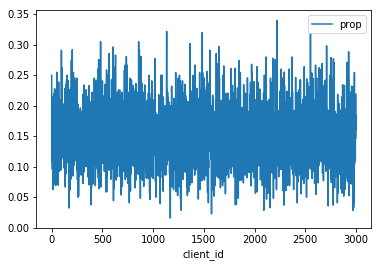

In [81]:
# Calcul du taux de retard par un an
retard = histories.loc[histories['late_time'] != 0]
print(float(retard.shape[0]/histories.shape[0]))

# Taux de retard par un client
agg = retard.groupby(['client_id']).size().to_frame(name='late_time')
agg2 = histories.groupby(['client_id']).size().to_frame(name='counts')
agg['use_time'] = agg2['counts']
agg['prop'] = agg['late_time']/agg['use_time']

# Calculate mean
print(agg.mean(axis=0))
#plt.scatter(agg['client_id'], agg['prop'])
agg.drop(['use_time','late_time'], axis=1).plot(kind='line')
plt.show()

In [82]:
agg = retard.groupby(['DATE']).size().to_frame(name='retard_times')
agg.reset_index(inplace=True)
agg['visibility'] = weather.groupby('DATE')['VISIBILITY_AVG_KM'].transform(lambda x: x)
agg['precipitation'] = weather.groupby('DATE')['PRECIP_TOTAL_DAY_MM'].transform(lambda x: x)
#agg.head(10)
# Calcule les correlations entre 'retard times', 'visibility' et 'precipitation'
agg.corr()

,retard_times,visibility,precipitation
retard_times,1.000000,-0.219690,0.560496
visibility,-0.219690,1.000000,-0.165959
precipitation,0.560496,-0.165959,1.000000


In [85]:
# Linear regression to predict the late model
import statsmodels.api as sm

X = agg[['precipitation', 'visibility']]
y = agg['retard_times']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

# With linear regression, R-squared is just 59%.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           retard_times   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     254.9
Date:                Fri, 08 Feb 2019   Prob (F-statistic):           2.73e-69
Time:                        12:08:37   Log-Likelihood:                -2033.6
No. Observations:                 356   AIC:                             4071.
Df Residuals:                     354   BIC:                             4079.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
precipitation    10.0556      0.741     13.565      0.000       8.598      11.513
visibility        4.8684      0.440     11.061      0.000       4.003       5.734
==============================================================================
Omnibus:                       92.153   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              759.285
Skew:                           0.820   Prob(JB):                    1.33e-165
Kurtosis:                       9.964   Cond. No.                         1.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

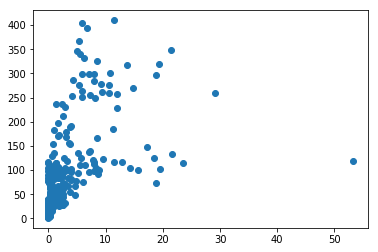

In [86]:
# Try to classification
plt.scatter(agg['precipitation'], agg['retard_times'])

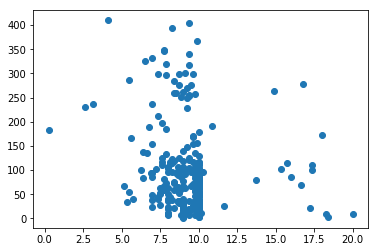

In [87]:
plt.scatter(agg['visibility'], agg['retard_times'])

In [90]:
import numpy as np
real_y = X_test['retard_times'].tolist()
bias = 0
for index,i in enumerate(real_y):
    bias += np.abs(i - y[index])
# Mean bias of daily late time 
print(bias/len(real_y))

74.23364485981308


In [77]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

random_state = np.random.RandomState(0)
# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(x_train, y_train)
y_score = classifier.decision_function(x_test)

In [62]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.35


In [11]:
import pandas as pd
booking = pd.read_csv("bookings.csv")


In [12]:
weather = pd.read_csv("weather2018.csv")
booking['DATE'] = pd.to_datetime(booking['dep_time'], format = '%Y-%m-%d').dt.date
weather['DATE'] = pd.to_datetime(weather['DATE'], format = '%Y-%m-%d').dt.date
booking['precipitation'] = booking['DATE'].map(weather.set_index('DATE')['PRECIP_TOTAL_DAY_MM'])
booking['visibility'] = booking['DATE'].map(weather.set_index('DATE')['VISIBILITY_AVG_KM'])
booking['month'] = pd.to_datetime(booking['dep_time'], format = '%Y-%m-%d').dt.month
booking['hour'] = pd.to_datetime(booking['dep_time'], format = '%Y-%m-%d').dt.hour
booking.head(10)

,id,client_id,departure_id,arrival_id,dep_time,estimate_arr_time,price,DATE,precipitation,visibility,month,hour
0,1,2219,92,16,2018-08-04 00:11:00,2018-08-04 00:57:00,8.28,2018-08-04,0.2,9.375,8,0
1,2,2701,139,62,2018-08-04 00:18:00,2018-08-04 00:23:00,2.00,2018-08-04,0.2,9.375,8,0
2,3,1947,2,36,2018-08-04 00:47:00,2018-08-04 01:33:00,4.74,2018-08-04,0.2,9.375,8,0
3,4,1389,125,35,2018-08-04 00:52:00,2018-08-04 01:36:00,21.95,2018-08-04,0.2,9.375,8,0
4,5,681,68,165,2018-08-04 00:01:00,2018-08-04 00:03:00,2.00,2018-08-04,0.2,9.375,8,0
5,6,2927,111,144,2018-08-04 00:13:00,2018-08-04 00:16:00,2.00,2018-08-04,0.2,9.375,8,0
6,7,2079,129,98,2018-08-04 00:00:00,2018-08-04 00:15:00,3.30,2018-08-04,0.2,9.375,8,0
7,8,1125,28,124,2018-08-04 01:40:00,2018-08-04 02:33:00,29.82,2018-08-04,0.2,9.375,8,1
8,9,526,63,131,2018-08-04 01:17:00,2018-08-04 02:10:00,23.07,2018-08-04,0.2,9.375,8,1
9,10,2968,2,99,2018-08-04 01:38:00,2018-08-04 02:07:00,6.69,2018-08-04,0.2,9.375,8,1


In [13]:
predFait = booking.drop(['id','client_id', 'departure_id', 'arrival_id',\
                       'dep_time', 'estimate_arr_time', 'price'], axis=1)
predFait.to_csv("FaitAPred.csv")